In [1]:
import sys
sys.path.append('/data/ivan/work/dlzoo4')

In [2]:
import urllib
from collections import defaultdict

import scipy
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl

from mpl_settings import beautify_mpl, make_up_axis

from deeplite_torch_zoo.utils import get_pareto_set

beautify_mpl(figsize=(8, 6))

/home/ivan/.virtualenvs/nncf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-27 17:24:49.352764: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
DATA_URL = 'https://raw.githubusercontent.com/Deeplite/deeplite-torch-zoo/develop/results/yolobench/'
df = pd.read_csv(urllib.parse.urljoin(DATA_URL, 'merged_results.csv'))
df_scratch = pd.read_csv(urllib.parse.urljoin(DATA_URL, 'VOC_scratch_100epochs.csv'))

In [4]:
metrics = ['precision', 'recall', 'mAP_0.5', 'mAP_0.5:0.95']

scratch = defaultdict(list)
for name in df.model_name:
    for metric_name in metrics:
        scratch[f'{metric_name}_scratch'].append(df_scratch[df_scratch.model_name == name][metric_name].values[0])

for key in scratch:
    df[key] = scratch[key]

In [5]:
df.columns

Index(['mAP_0.5:0.95_voc', 'mAP_0.5_voc', 'precision_voc', 'recall_voc',
       'mAP_0.5:0.95_sku', 'mAP_0.5_sku', 'precision_sku', 'recall_sku',
       'mAP_0.5:0.95_wider', 'mAP_0.5_wider', 'precision_wider',
       'recall_wider', 'mAP_0.5:0.95_coco', 'mAP_0.5_coco', 'precision_coco',
       'recall_coco', 'nano_gpu_latency', 'openvino_latency', 'vim3_latency',
       'raspi4_tflite_latency', 'model_name', 'model_family',
       'precision_scratch', 'recall_scratch', 'mAP_0.5_scratch',
       'mAP_0.5:0.95_scratch'],
      dtype='object')

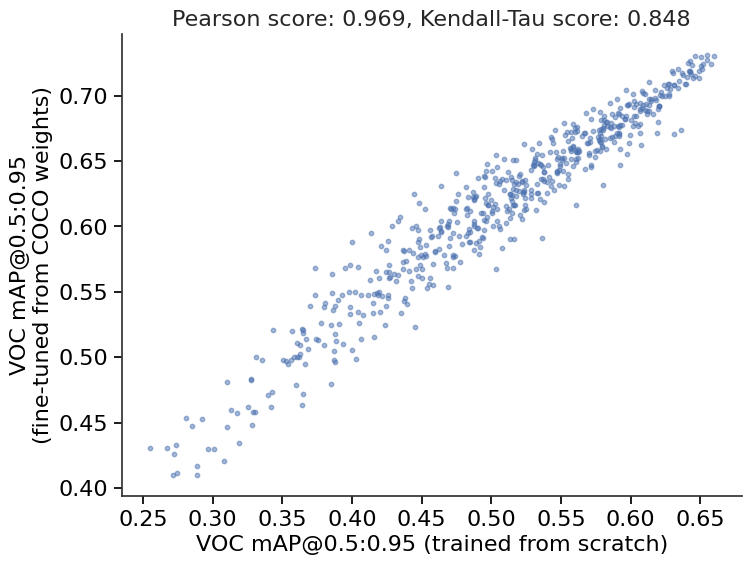

In [6]:


x, y = df['mAP_0.5:0.95_scratch'].astype(np.float32), df['mAP_0.5:0.95_voc'].astype(np.float32)

plt.scatter(x, y, s=10, alpha=0.5)

kt = scipy.stats.kendalltau(x, y).statistic
pr = scipy.stats.pearsonr(x, y).statistic

plt.title(f'Pearson score: {pr:.3f}, Kendall-Tau score: {kt:.3f}')
plt.xlabel('VOC mAP@0.5:0.95 (trained from scratch)')
plt.ylabel('VOC mAP@0.5:0.95\n(fine-tuned from COCO weights)')

make_up_axis()

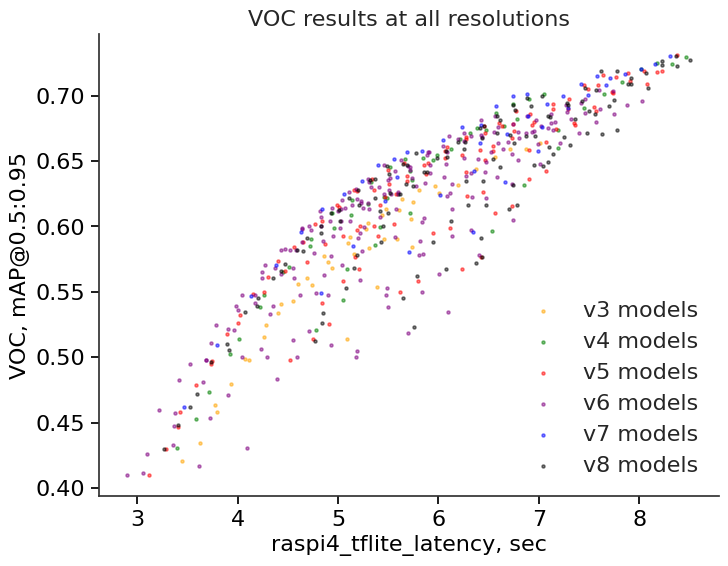

In [7]:
idx = {}
for tag in range(3, 9):
    idx[tag] = [idx for idx, name in enumerate(df.model_name.values) if f'yolo{tag}' in name.split('_')[0]]


metric = 'mAP_0.5:0.95_voc'
latency = 'raspi4_tflite_latency'

colors = ('orange', 'green', 'red', 'purple', 'blue', 'black')

for i, tag in enumerate(range(3, 9)):
    plt.scatter(np.log(df.iloc[idx[tag]][latency].values), 
                df.iloc[idx[tag]][metric].values, color=colors[i], s=5, alpha=0.5) 


plt.xlabel(f'{latency}, sec')
plt.ylabel('VOC, mAP@0.5:0.95')

plt.legend(['v3 models', 'v4 models', 'v5 models', 'v6 models', 'v7 models', 'v8 models'])
plt.title('VOC results at all resolutions')

make_up_axis()

In [8]:
p = {}

for acc_key in (
    'mAP_0.5:0.95_voc',
    'mAP_0.5:0.95_sku',
    'mAP_0.5:0.95_wider',
    'mAP_0.5:0.95_coco',
):
    p[acc_key] = {}
    for latency_key in (
            'nano_gpu_latency', 
            'openvino_latency', 
            'raspi4_tflite_latency', 
            'vim3_latency',
        ):
        p[acc_key][latency_key] = {}
        ignore_indices = []
        for j in range(1, 6):
            pareto_set = get_pareto_set(df[latency_key].values, df[acc_key].values, ignore_indices=ignore_indices) 
            p[acc_key][latency_key][j] = pareto_set
            ignore_indices += pareto_set

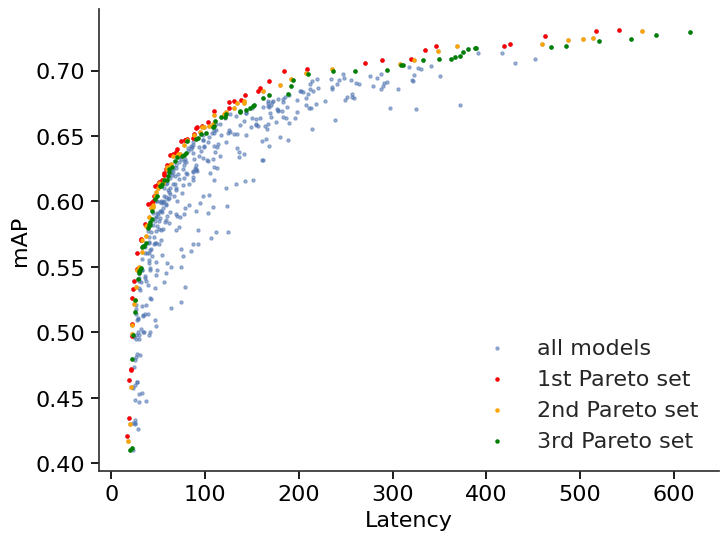

In [9]:
acc_key = 'mAP_0.5:0.95_voc'
latency_key = 'nano_gpu_latency'

frontiers = p[acc_key][latency_key]

plt.scatter(
    df[latency_key], df[acc_key], s=5, alpha=0.5
)

plt.scatter(
    df[latency_key][frontiers[1]], 
    df[acc_key][frontiers[1]], 
    color='red', s=5
)

plt.scatter(
    df[latency_key][frontiers[2]], 
    df[acc_key][frontiers[2]], 
    color='orange', s=5
)

plt.scatter(
    df[latency_key][frontiers[3]], 
    df[acc_key][frontiers[3]], 
    color='green', s=5
)

plt.legend(['all models', '1st Pareto set', '2nd Pareto set', '3rd Pareto set'])

plt.xlabel('Latency')
plt.ylabel('mAP')

make_up_axis()

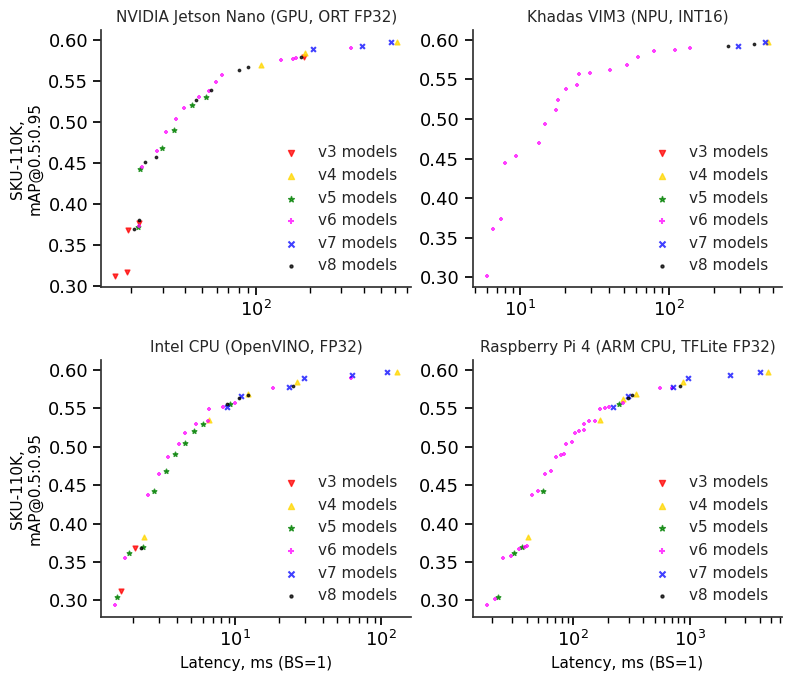

In [20]:
acc_key = 'mAP_0.5:0.95_sku'

fig, axs = plt.subplots(2, 2)

device_tag = {
    'openvino_latency': 'Intel CPU (OpenVINO, FP32)',
    'nano_gpu_latency': 'NVIDIA Jetson Nano (GPU, ORT FP32)',
    'vim3_latency': 'Khadas VIM3 (NPU, INT16)',
    'raspi4_tflite_latency': 'Raspberry Pi 4 (ARM CPU, TFLite FP32)',
}

sub = {
    'nano_gpu_latency': (0, 0),
    'vim3_latency': (0, 1),
    'openvino_latency': (1, 0),
    'raspi4_tflite_latency': (1, 1),
}

for latency in (
        'nano_gpu_latency', 
        'vim3_latency',
        'openvino_latency',  
        'raspi4_tflite_latency', 
    ):

    idx = {}
    for tag in range(3, 9):
        idx[tag] = [idx for idx, name in enumerate(df.model_name.values) 
                        if f'yolo{tag}' in name.split('_')[0] and idx in p[acc_key][latency][1]]

    colors = ('red', 'gold', 'green', 'magenta', 'blue', 'black')
    markers = ('v', '^', '*', '+', 'x', '.')

    for i, tag in enumerate(range(3, 9)):
        axs[sub[latency]].scatter(
            df.iloc[idx[tag]][latency].values,  
            df.iloc[idx[tag]][acc_key].values, 
            color=colors[i], s=12, alpha=0.75, marker=markers[i]
        ) 
        
        axs[sub[latency]].set_xscale('log')
        
        make_up_axis(axs[sub[latency]])
        if sub[latency][0] == 1:
            axs[sub[latency]].set_xlabel('Latency, ms (BS=1)', fontsize=11)
        
        axs[sub[latency]].set_title(device_tag[latency], fontsize=11)
        if sub[latency] in [(1, 0), (0, 0)]:
            # axs[sub[latency]].set_ylabel('VOC (fine-tuned),\nmAP@0.5:0.95', fontsize=11)
            axs[sub[latency]].set_ylabel('SKU-110K,\nmAP@0.5:0.95', fontsize=11)
            # axs[sub[latency]].set_ylabel('WIDER FACE,\nmAP@0.5:0.95', fontsize=11)

        axs[sub[latency]].legend(
            ['v3 models', 'v4 models', 'v5 models', 'v6 models', 'v7 models', 'v8 models'],
            loc='lower right', markerscale=1.25, fontsize=11
        )

plt.tight_layout()
beautify_mpl(figsize=(8, 7), fontsize=13)

plt.savefig('_sku.svg', format='svg')

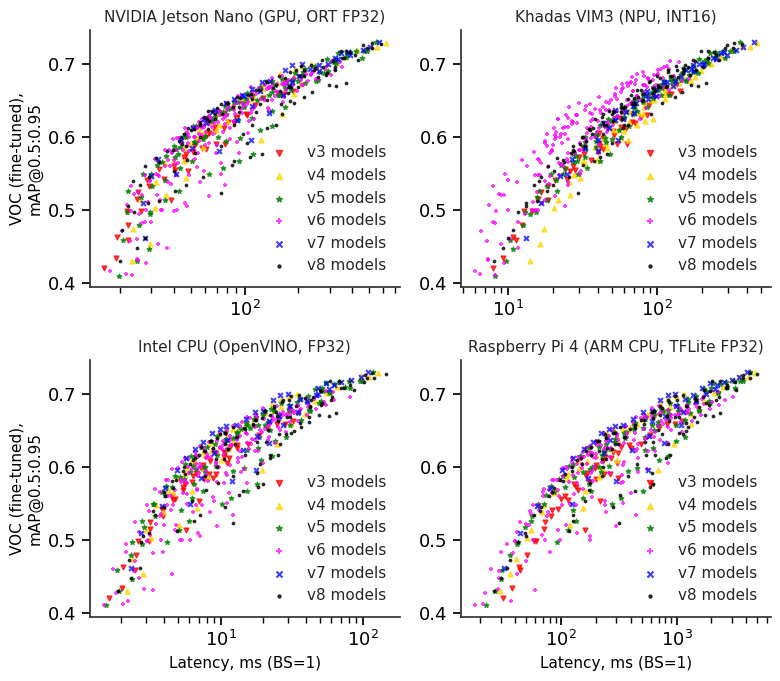

In [11]:
acc_key = 'mAP_0.5:0.95_voc'

fig, axs = plt.subplots(2, 2)

device_tag = {
    'openvino_latency': 'Intel CPU (OpenVINO, FP32)',
    'nano_gpu_latency': 'NVIDIA Jetson Nano (GPU, ORT FP32)',
    'vim3_latency': 'Khadas VIM3 (NPU, INT16)',
    'raspi4_tflite_latency': 'Raspberry Pi 4 (ARM CPU, TFLite FP32)',
}

sub = {
    'nano_gpu_latency': (0, 0),
    'vim3_latency': (0, 1),
    'openvino_latency': (1, 0),
    'raspi4_tflite_latency': (1, 1),
}

for latency in (
        'nano_gpu_latency', 
        'vim3_latency',
        'openvino_latency',  
        'raspi4_tflite_latency', 
    ):

    idx = {}
    for tag in range(3, 9):
        idx[tag] = [idx for idx, name in enumerate(df.model_name.values) 
                        if f'yolo{tag}' in name.split('_')[0]]

    colors = ('red', 'gold', 'green', 'magenta', 'blue', 'black')
    markers = ('v', '^', '*', '+', 'x', '.')

    for i, tag in enumerate(range(3, 9)):
        axs[sub[latency]].scatter(
            df.iloc[idx[tag]][latency].values,  
            df.iloc[idx[tag]][acc_key].values, 
            color=colors[i], s=12, alpha=0.75, marker=markers[i]
        ) 
        
        axs[sub[latency]].set_xscale('log')
        
        make_up_axis(axs[sub[latency]])
        if sub[latency][0] == 1:
            axs[sub[latency]].set_xlabel('Latency, ms (BS=1)', fontsize=11)
        
        axs[sub[latency]].set_title(device_tag[latency], fontsize=11)
        if sub[latency] in [(1, 0), (0, 0)]:
            axs[sub[latency]].set_ylabel('VOC (fine-tuned),\nmAP@0.5:0.95', fontsize=11)

        axs[sub[latency]].legend(
            ['v3 models', 'v4 models', 'v5 models', 'v6 models', 'v7 models', 'v8 models'],
            loc='lower right', markerscale=1.25, fontsize=11
        )

plt.tight_layout()
beautify_mpl(figsize=(9, 9), fontsize=13)

plt.savefig('_voc_full.svg', format='svg')